In [1]:
import os.path

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Training data

In [15]:
from src.dataset.denoise import DenoisingDataset

configs={
    "data_dir": "data",
    "phase": 'val',
    "stride": 9,
    "normalize": False,
    "clip": True,
    "sigma": 25,
    "output_mode": "image",
}

dataset = DenoisingDataset(**configs)

Data gen patches: 100%|██████████| 84/84 [00:02<00:00, 41.03it/s]
2023-12-17 21:47:17.893 | INFO     | src.dataset:datagenerator:97 - Số ảnh val:77280
2023-12-17 21:47:17.894 | SUCCESS  | src.dataset.denoise:__init__:51 - val with mode: image - sigma: 25 - clip: True - normalize: False - with_map: False


In [16]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset=dataset, batch_size=1, num_workers=1,)

In [17]:
ori_images = []
noise_images = []
n_collect = 16
for i, data in enumerate(dataloader):
    noise_image, ori_image = data[0], data[1]
    ori_images.append(ori_image.cpu().detach().squeeze(0).numpy().transpose(1,2,0).astype(np.uint8))
    noise_images.append(noise_image.cpu().detach().squeeze(0).numpy().transpose(1,2,0).astype(np.uint8))
    if i == n_collect:
        break


In [ ]:
# Create a subplot with a 4x4 grid (assuming 16 images)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the axs array to make it easier to iterate over
axs = axs.flatten()

# Iterate through the images and plot them
for i in range(len(noise_images)):
    axs[i].imshow(noise_images[i], cmap='gray')  # Assuming the images are grayscale, adjust cmap as needed
    axs[i].axis('off')  # Turn off axis labels for cleaner visualization

plt.show()

# 2. Get result on test dataset

In [2]:
sigmas = [10, 25, 35, 45, 55]

strategy_configs = {
    "1":{
        "model": ["dncnn"],
        "model_configs":{
                "layers": 10,
                "input_channels": 1,
                "out_channels": 1,
                "feature": 192,
                "weigth_path": "result/layers_dncnn10_Falseclip_Truenormalize_sigrange10_10_image/model_025.pth",
        },
        "range_sigma": sigmas,
        "step": 5,
        "data_path": "data",
        "n_workers": 8,
        "batch_size": 1,
        "normalize": True,
        "clip": False,
        "device": 'cuda:0',
        "output_mode": 'image',
        "with_map": False
    },
    "2":{
        "model": ["dnresnet"],
        "model_configs":{
                "layers": 10,
                "input_channels": 1,
                "out_channels": 1,
                "feature": 192,
                "weigth_path": "result/layers_dnresnet10_Falseclip_Truenormalize_sigrange10_10_image/model_017.pth",
        },
        "range_sigma": sigmas,
        "step": 5,
        "data_path": "data",
        "n_workers": 8,
        "batch_size": 1,
        "normalize": True,
        "clip": False,
        "device": 'cuda:0',
        "output_mode": 'image',
        "with_map": False
    },
    "3":{
        "model": ["dnresnet"],
        "model_configs":{
                "layers": 10,
                "input_channels": 1,
                "out_channels": 1,
                "feature": 192,
                "weigth_path": "result/layers_dnresnet10_Falseclip_Truenormalize_sigrange10_10_noise/model_010.pth",
        },
        "range_sigma": sigmas,
        "step": 5,
        "data_path": "data",
        "n_workers": 8,
        "batch_size": 1,
        "normalize": True,
        "clip": False,
        "device": 'cuda:0',
        "output_mode": 'noise',
        "with_map": False
    },
    "4":{
        "model": ["dnresnet"],
        "model_configs":{
                "layers": 10,
                "input_channels": 2,
                "out_channels": 1,
                "feature": 192,
                "weigth_path": "result/layers_dnresnet10_Falseclip_Truenormalize_sigrange10_10_image_withMap/model_040.pth",
        },
        "range_sigma": sigmas,
        "step": 5,
        "data_path": "data",
        "n_workers": 8,
        "batch_size": 1,
        "normalize": True,
        "clip": False,
        "device": 'cuda:0',
        "output_mode": 'image',
        "with_map": True
    },
    "5":{
        "model": ["dnresnet", "fcn"],
        "model_configs":{
            "denoise":
                  {"layers": 10,
                   "input_channels": 2,
                   "out_channels": 1,
                   "feature": 192, },
            "noisemap":
                  {"model_name": 'fcn',
                   "layers": 5,
                   "input_channels": 1,
                   "feature": 32, },
            "weigth_path": "result/hybrid_dnresnet_fcn_Falseclip_Truenormalize_sigrange10_25_image_withMap/model_003.pth"
        },
        "range_sigma": sigmas,
        "step": 5,
        "data_path": "data",
        "n_workers": 8,
        "batch_size": 1,
        "normalize": True,
        "clip": False,
        "device": 'cuda:0',
        "output_mode": 'image',
        "with_map": False
    },

}

In [3]:
import glob
import os
import torch

from src.model.hybrid import HybridNet
from torchvision import transforms
from src.dataset import read_npy
from src.model.utils import get_model


transform = transforms.ToTensor()
# data_paths = lambda sigma: glob.glob(f"data/test/sigma_{sigma}/*.npy")
def show_im(im, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    if isinstance(im, list):
        plt.imshow(np.hstack([i for i in im]), cmap="gray")
    else:
        plt.imshow(im, cmap="gray")
    plt.show()

def get_infor(data, lib="torch"):
    lib = torch if lib == "torch" else np
    return f"Max: {lib.max(data)} - Min: {lib.min(data)}"


def create_data(npy_path, sigma, return_path, config):
    output = read_npy(npy_path)
    # Noise
    noise1 = np.random.randn(output.shape[0], output.shape[1]) * sigma
    noise2 = np.random.randn(output.shape[0], output.shape[1]) * sigma

    # Noisy Image
    noisy_img = np.sqrt((output + noise1) * (output + noise1) + noise2 * noise2)

    if config["output_mode"]!='image':
        # Noisy
        output = transform((noisy_img - output).astype(np.int32)).float()
    else:
        # CLean Image
        output = transform(output.astype(np.int32)).float()
    # logger.success(get_infor(noisy_img, 'numpy'))
    noisy_img = transform(noisy_img.astype(np.int32)).float()
    # logger.success(get_infor(noisy_img))

    noise_map = torch.ones_like(noisy_img) * sigma

    if config['clip']:
        noise_map = noise_map.clamp(0, 255)
        output = output.clamp(0, 255)
        noisy_img = noisy_img.clamp(0, 255)

    if config['normalize']:
        noise_map = noise_map.div(255)
        output = output.div(255)
        noisy_img = noisy_img.div(255)
    # logger.success(get_infor(noisy_img))

    # if config['with_map']:
    #     noisy_img = torch.cat((noisy_img, noise_map), dim=0)

    if return_path:
        return noisy_img.unsqueeze(0), noise_map.unsqueeze(0), output.unsqueeze(0), npy_path
    else:
        return noisy_img.unsqueeze(0), noise_map.unsqueeze(0), output.unsqueeze(0)

def initialize_model(model_names, model_configs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if len(model_names) == 1:
        logger.success(model_names[0])
        logger.success(model_configs)
        model = get_model(name=model_names[0], **model_configs)

    else:
        denoise_model = get_model(
        name=model_names[0], **model_configs["denoise"]
        )
        print(model_names[1])
        noisemap_model = get_model(name=model_names[1], **model_configs["noisemap"])

        model = HybridNet(denoise_net=denoise_model, noisemap_net=noisemap_model)


    check_point = torch.load(model_configs["weigth_path"])
    model.load_state_dict(check_point)
    model.eval()
    # model = torch.load(os.path.join(save_dir, "model_%03d.pth" % initial_epoch))
    model.to(device)
    return model

2023-12-28 21:08:41.506 | SUCCESS  | __main__:initialize_model:69 - dncnn
2023-12-28 21:08:41.507 | SUCCESS  | __main__:initialize_model:70 - {'layers': 10, 'input_channels': 1, 'out_channels': 1, 'feature': 192, 'weigth_path': 'result/layers_dncnn10_Falseclip_Truenormalize_sigrange10_10_image/model_025.pth'}


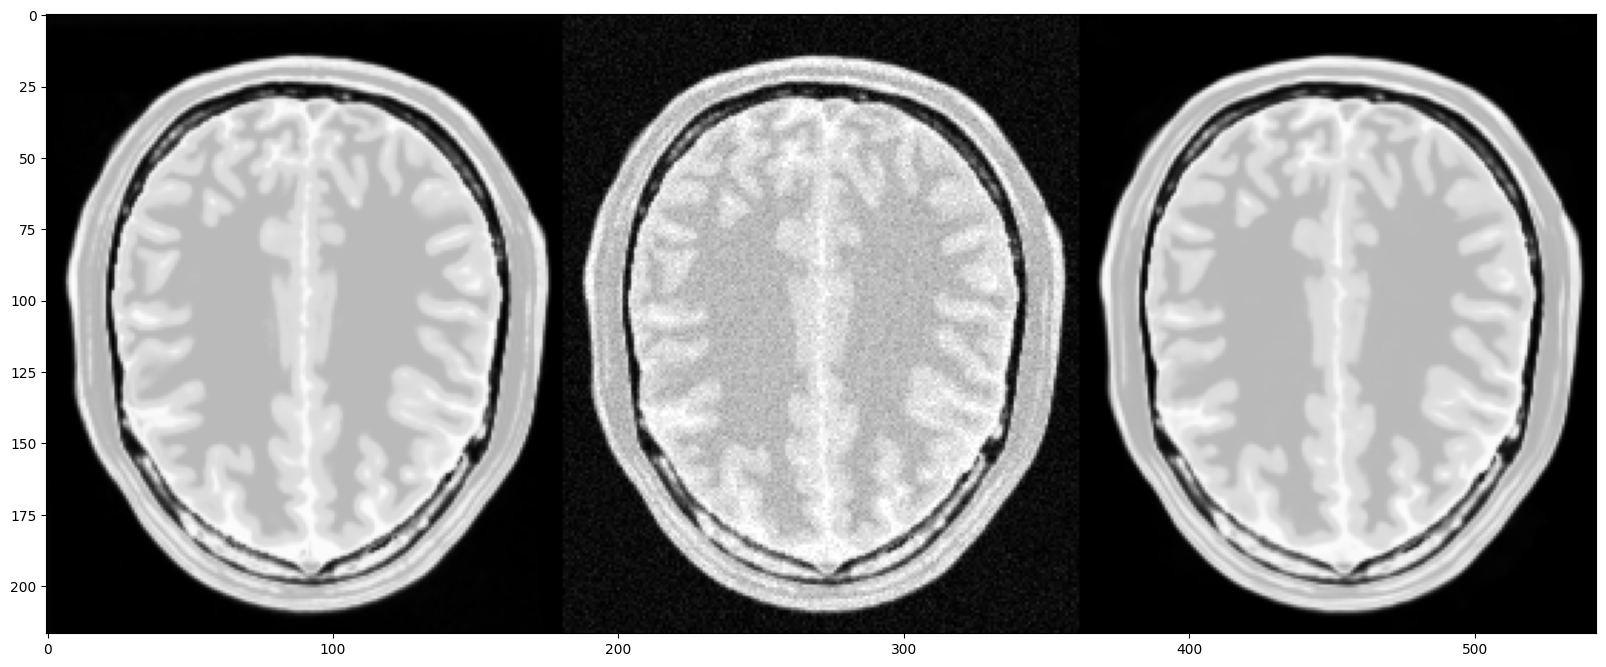

2023-12-28 21:08:42.787 | SUCCESS  | __main__:initialize_model:69 - dnresnet
2023-12-28 21:08:42.789 | SUCCESS  | __main__:initialize_model:70 - {'layers': 10, 'input_channels': 1, 'out_channels': 1, 'feature': 192, 'weigth_path': 'result/layers_dnresnet10_Falseclip_Truenormalize_sigrange10_10_image/model_017.pth'}


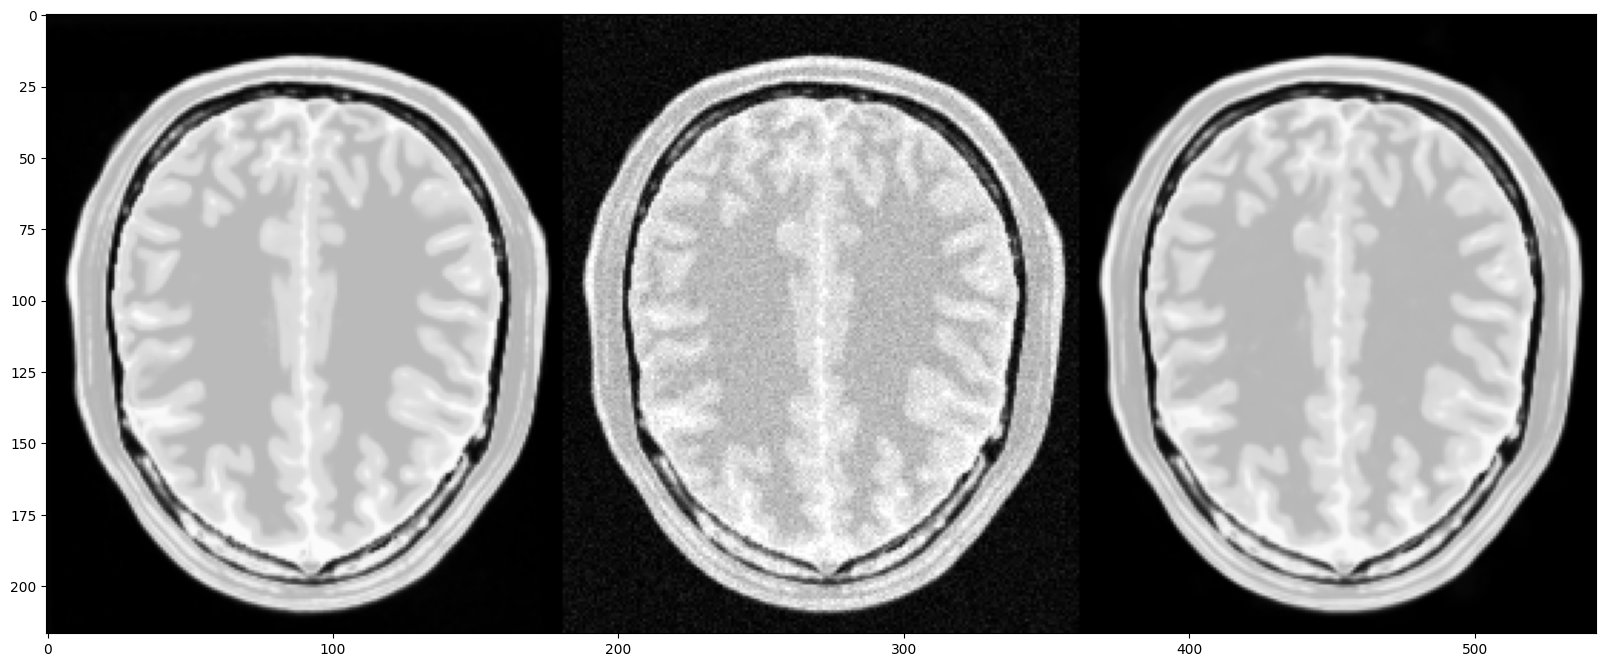

2023-12-28 21:08:43.523 | SUCCESS  | __main__:initialize_model:69 - dnresnet
2023-12-28 21:08:43.524 | SUCCESS  | __main__:initialize_model:70 - {'layers': 10, 'input_channels': 1, 'out_channels': 1, 'feature': 192, 'weigth_path': 'result/layers_dnresnet10_Falseclip_Truenormalize_sigrange10_10_noise/model_010.pth'}


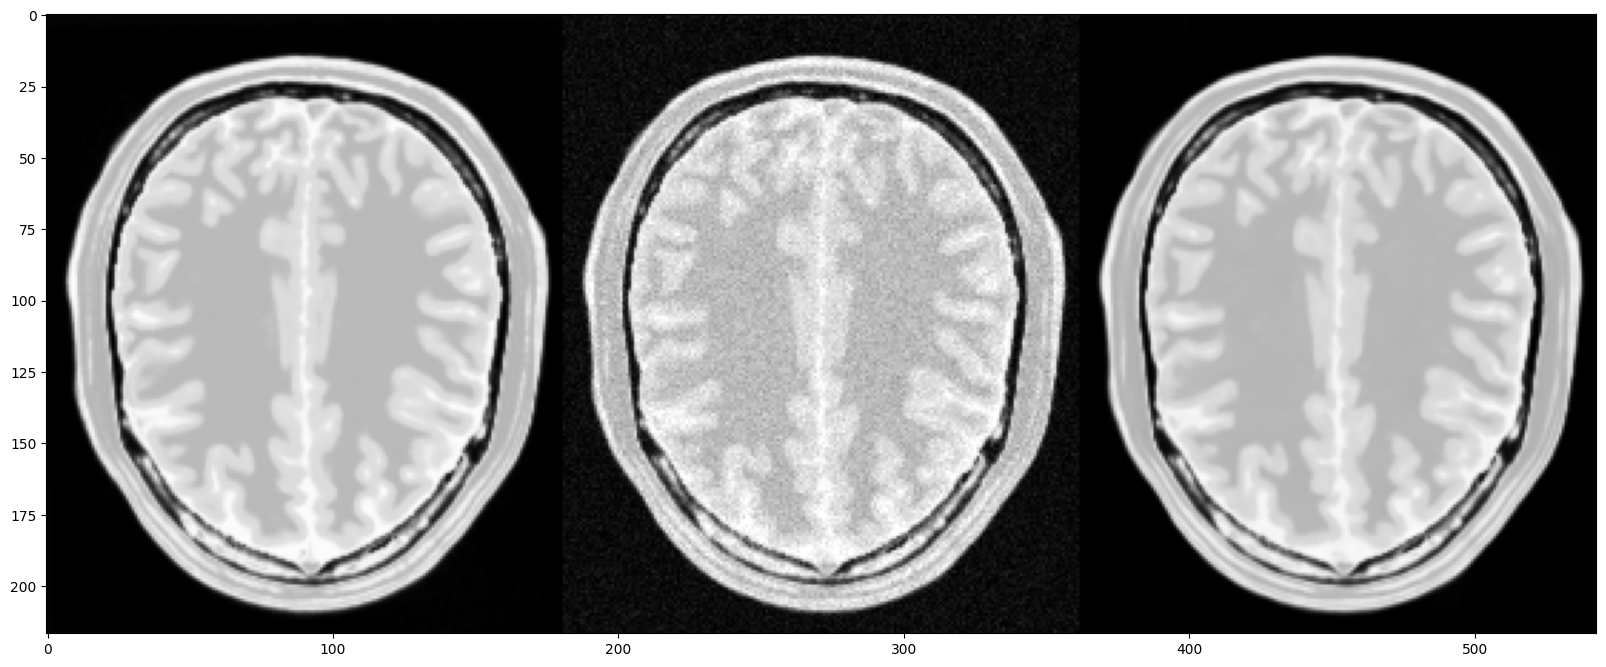

2023-12-28 21:08:44.371 | SUCCESS  | __main__:initialize_model:69 - dnresnet
2023-12-28 21:08:44.373 | SUCCESS  | __main__:initialize_model:70 - {'layers': 10, 'input_channels': 2, 'out_channels': 1, 'feature': 192, 'weigth_path': 'result/layers_dnresnet10_Falseclip_Truenormalize_sigrange10_10_image_withMap/model_040.pth'}


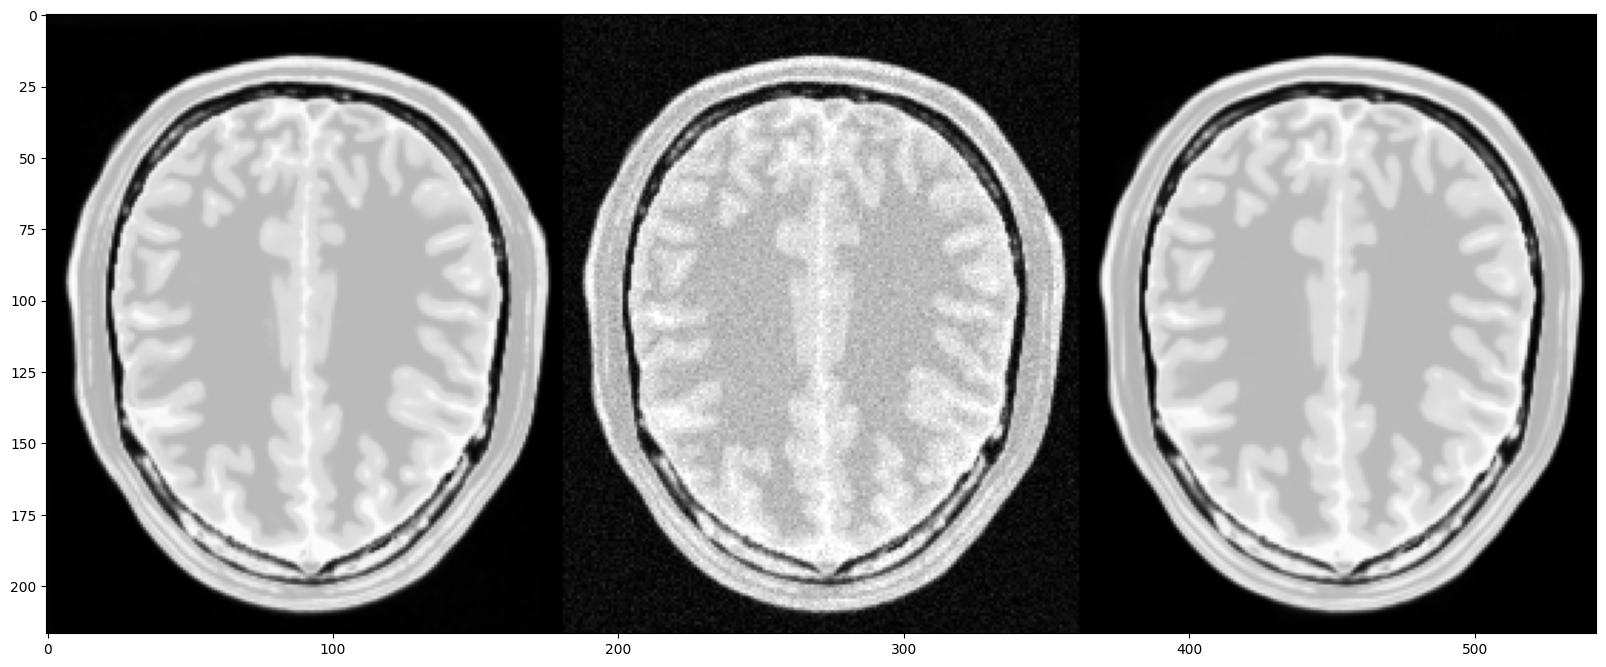

fcn


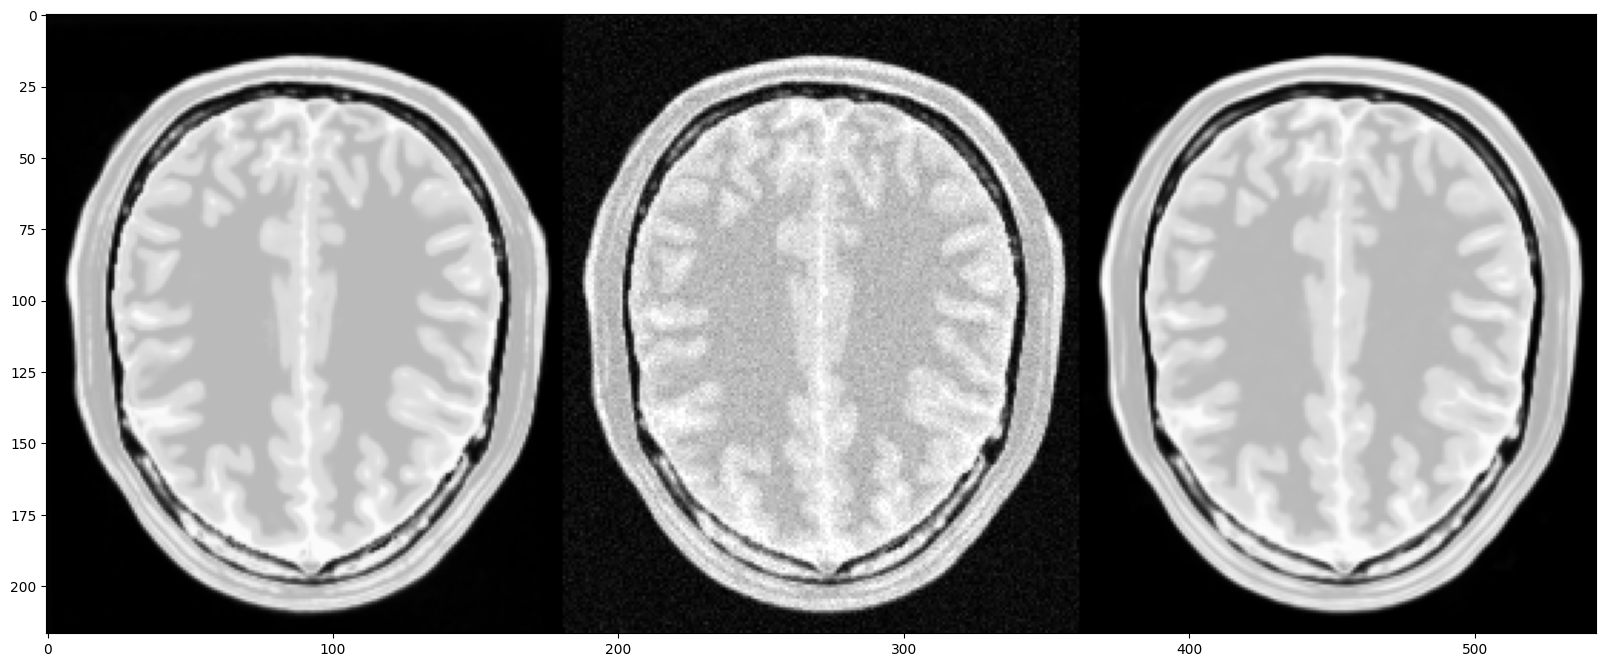

In [5]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from loguru import logger
import sys

logger.remove()
logger.add(sys.stderr, level="SUCCESS")

data_paths = glob.glob(f"data/test/origin/*.npy")

results = {}
for key, value in strategy_configs.items():
    results[key] = {}
    model = initialize_model(value['model'], value['model_configs'])
    for sigma in sigmas:
        results[key][sigma] = {}
        for data_path in data_paths:
            noisy_img, noise_map, output = create_data(
                                    npy_path=data_path,
                                    sigma=sigma,
                                    return_path=False,
                                    config=value
                                )
            noisy_img, noise_map, output = noisy_img.cuda(), noise_map.cuda(), output.cuda()

            # logger.success(get_infor(noisy_img))
            # logger.success(get_infor(output))

            if key == "5":
                predicted_noise_level, predicted_output = model(noisy_img.cuda())
            elif key =="4":
                predicted_output = model(torch.cat((noisy_img, noise_map), dim=1))
            else:
                predicted_output = model(noisy_img.cuda())
            # logger.success(get_infor(predicted_output))

            output = output.cuda()

            if value['output_mode'] != 'image':
                clean_imgs = noisy_img - output
                denoise_imgs = noisy_img - predicted_output
            else:
                clean_imgs = output
                denoise_imgs = predicted_output

            if value['normalize']:
                clean_imgs = clean_imgs * 255
                denoise_imgs = denoise_imgs * 255
                try:
                    predicted_noise_level = predicted_noise_level * 55
                except:
                    pass
                noise_map = noise_map * 55

            clean_imgs = clean_imgs.clamp(0, 255)
            denoise_imgs = denoise_imgs.clamp(0, 255)
            clean_imgs = clean_imgs.cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
            denoise_imgs = denoise_imgs.cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)

            if noisy_img.shape[1] == 2:
                print(get_infor(noisy_img[:,1,:,:]))

                noisy_img = noisy_img[:,0,:,:]
                noisy_img = (noisy_img*255).clamp(0,255).cpu().detach().numpy().astype(np.uint8).squeeze(0)
            else:
                noisy_img = (noisy_img*255).clamp(0,255).cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
            show_im([clean_imgs, noisy_img, denoise_imgs])

            # clean_imgs = label.cpu().detach().squeeze(0).squeeze(0).numpy().astype(np.uint8)
            #
            # denoise_imgs = predict.cpu().detach().squeeze(0).squeeze(0).numpy().astype(np.uint8)
            #
            # results[key][sigma][image_name]['psnr'] = psnr(clean_imgs, denoise_imgs)
            # results[key][sigma][image_name]['ssim'] = ssim(clean_imgs, denoise_imgs)
            break
        break

    # logger.success(f"--------------------------{value['model']}--------------------------")


In [15]:
import cv2
import glob
import os
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
sigmas = [10, 25, 35, 45, 55]

origin_image_folder = "report/LV_ThS_TuPhuongNguyen/LuanVan/origin"

strategy_image_folders ={
    'strategy1': "report/LV_ThS_TuPhuongNguyen/LuanVan/strategy1",
    'strategy2': "report/LV_ThS_TuPhuongNguyen/LuanVan/strategy2",
    'strategy3': "report/LV_ThS_TuPhuongNguyen/LuanVan/strategy3",
    'strategy4': "report/LV_ThS_TuPhuongNguyen/LuanVan/strategy4",
    'strategy5': "report/LV_ThS_TuPhuongNguyen/LuanVan/strategy5",
}

In [25]:
def calculate_metric(original_image, denoise_image):
    return {"psnr": round(psnr(original_image, denoise_image), 2),
            "ssim": round(ssim(original_image, denoise_image), 4)}

In [26]:
result = {}
for key, value in strategy_image_folders.items():
    result[key] = {}
    for sigma in sigmas:
        result[key][sigma] = {}
        image_paths = glob.glob(f"{value}/sigma{sigma}/*.*")
        for image_path in image_paths[:21]:
            basename = os.path.basename(image_path)
            original_image_path = f"{origin_image_folder}/{basename}"

            denoise_img = cv2.imread(image_path)
            denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2GRAY)

            original_img = cv2.imread(original_image_path)
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

            result[key][sigma][basename] = calculate_metric(original_img, denoise_img)

In [30]:
# Convert JSON to a flat list of dictionaries
data_list = []

for strategy, sigma_data in result.items():
    for sigma, image_data in sigma_data.items():
        for image_path, metrics in image_data.items():
            data_list.append({
                'strategy': strategy,
                'sigma': sigma,
                'image_path': image_path,
                'psnr': metrics['psnr'],
                'ssim': metrics['ssim']
            })

# Create a DataFrame
df = pd.DataFrame(data_list)

# Save to CSV
df.to_csv('output_table.csv', index=False)

print("CSV file has been created successfully.")

CSV file has been created successfully.
